# **Homework 7 - Bert (Question Answering)**

If you have any questions, feel free to email us at mlta-2022-spring@googlegroups.com



Slide:    [Link](https://docs.google.com/presentation/d/1H5ZONrb2LMOCixLY7D5_5-7LkIaXO6AGEaV2mRdTOMY/edit?usp=sharing)　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw7)　Data: [Link](https://drive.google.com/uc?id=1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb)




## Task description
- Chinese Extractive Question Answering
  - Input: Paragraph + Question
  - Output: Answer

- Objective: Learn how to fine tune a pretrained model on downstream task using transformers

- Todo
    - Fine tune a pretrained chinese BERT model
    - Change hyperparameters (e.g. doc_stride)
    - Apply linear learning rate decay
    - Try other pretrained models
    - Improve preprocessing
    - Improve postprocessing
- Training tips
    - Automatic mixed precision
    - Gradient accumulation
    - Ensemble

- Estimated training time (tesla t4 with automatic mixed precision enabled)
    - Simple: 8mins
    - Medium: 8mins
    - Strong: 25mins
    - Boss: 2.5hrs
  

## Download Dataset

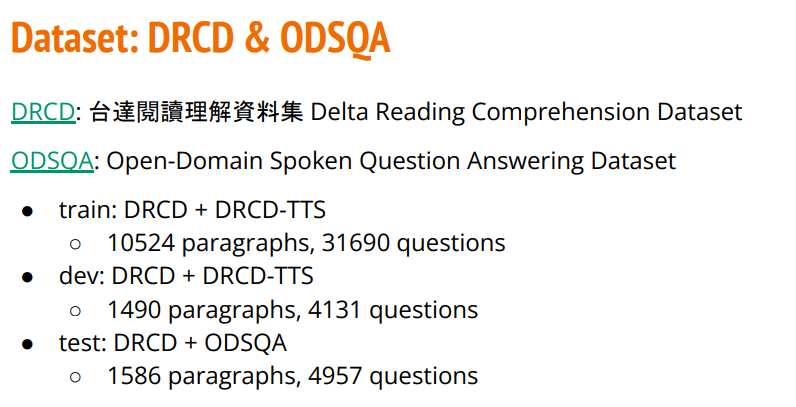

In [1]:
# # Download link 1
# !gdown --id '1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb' --output hw7_data.zip

# # Download Link 2 (if the above link fails) 
# # !gdown --id '1qwjbRjq481lHsnTrrF4OjKQnxzgoLEFR' --output hw7_data.zip

# # Download Link 3 (if the above link fails) 
# # !gdown --id '1QXuWjNRZH6DscSd6QcRER0cnxmpZvijn' --output hw7_data.zip

# !unzip -o hw7_data.zip

# # For this HW, K80 < P4 < T4 < P100 <= T4(fp16) < V100
# !nvidia-smi

## Install transformers

Documentation for the toolkit:　https://huggingface.co/transformers/

In [2]:
# You are allowed to change version of transformers or use other toolkits
!pip install transformers==4.5.0

## Import Packages

In [3]:
import json
import numpy as np
import random
import torch
from torch.utils.data import DataLoader, Dataset 
from transformers import AdamW, BertForQuestionAnswering, BertTokenizerFast

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

import inspect
from utils import same_seeds
lines = inspect.getsource(same_seeds)
print(lines)

same_seeds(0)

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True



In [4]:
# Change "fp16_training" to True to support automatic mixed precision training (fp16)	
fp16_training = True

if fp16_training:
    !pip install accelerate==0.2.0
    from accelerate import Accelerator
    accelerator = Accelerator(fp16=True)
    device = accelerator.device

# Documentation for the toolkit:  https://huggingface.co/docs/accelerate/

from utils import get_device
lines = inspect.getsource(get_device)
print(lines)

def get_device(fp16_training):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Change "fp16_training" to True to support automatic mixed precision training (fp16)	
    if fp16_training:
        # !pip install accelerate==0.2.0
        from accelerate import Accelerator
        accelerator = Accelerator(fp16=True)
        device = accelerator.device
        # Documentation for the toolkit:  https://huggingface.co/docs/accelerate/
        return accelerator, device 
    else: return None, device



## Load Model and Tokenizer


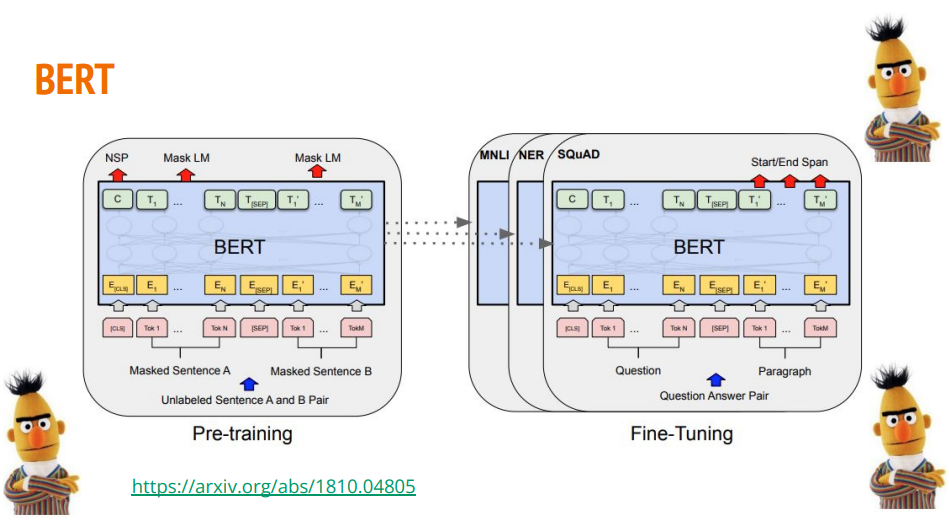

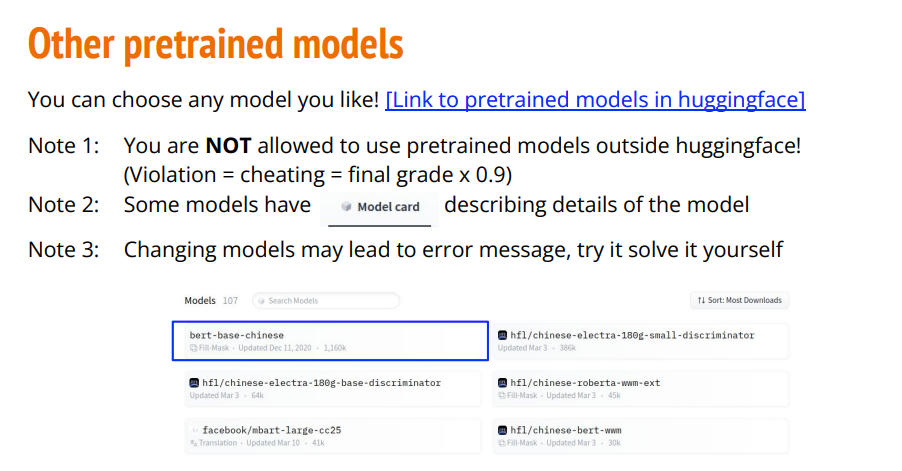
https://huggingface.co/models?sort=downloads&search=chinese

https://www.cnblogs.com/stephen-goodboy/p/12963757.html

https://xieyangyi.blog.csdn.net/article/details/106984080

In [5]:
# model_name = "bert-base-chinese"            # 0.732
# model_name = "hfl/chinese-bert-wwm-ext"       # 0.736
# model_name = "hfl/chinese-bert-wwm"           # 0.735
# model_name = "ckiplab/bert-base-chinese"           # 0.73
# model_name = "hfl/chinese-roberta-wwm-ext"           # 0.77
# model_name = "hfl/chinese-macbert-base"           # 0.76
# model_name = "alibaba-pai/pai-bert-base-zh"         # 0.76  
model_name = "hfl/chinese-macbert-large"           # b2, 0.8 too big

train_batch_size = 2


model = BertForQuestionAnswering.from_pretrained(model_name).to(device)
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# You can safely ignore the warning message (it pops up because new prediction heads for QA are initialized randomly)

Some weights of the model checkpoint at hfl/chinese-macbert-large were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the

## Read Data

- Training set: 31690 QA pairs
- Dev set: 4131  QA pairs
- Test set: 4957  QA pairs

- {train/dev/test}_questions:	
  - List of dicts with the following keys:
   - id (int)
   - paragraph_id (int)
   - question_text (string)
   - answer_text (string)
   - answer_start (int)
   - answer_end (int)
- {train/dev/test}_paragraphs: 
  - List of strings
  - paragraph_ids in questions correspond to indexs in paragraphs
  - A paragraph may be used by several questions 

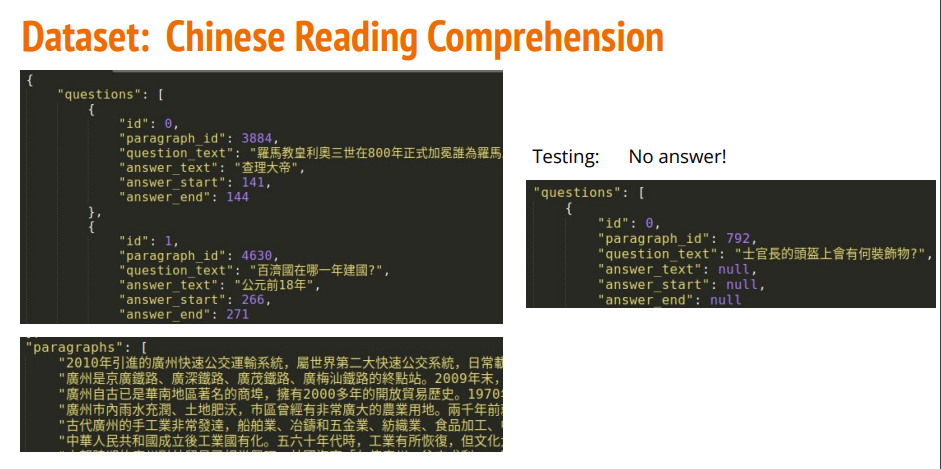

In [6]:
from utils import read_data
lines = inspect.getsource(read_data)
print(lines)

train_questions, train_paragraphs = read_data("hw7_train.json")
dev_questions, dev_paragraphs = read_data("hw7_dev.json")
test_questions, test_paragraphs = read_data("hw7_test.json")

def read_data(file):
    with open(file, 'r', encoding="utf-8") as reader:
        data = json.load(reader)
    return data["questions"], data["paragraphs"]    



## Tokenize Data

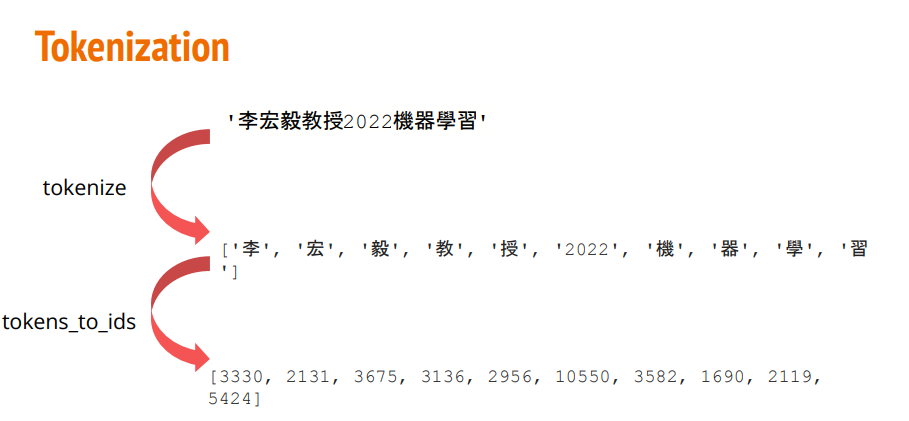

In [7]:
# Tokenize questions and paragraphs separately
# 「add_special_tokens」 is set to False since special tokens will be added when tokenized questions and paragraphs are combined in datset __getitem__ 

train_questions_tokenized = tokenizer([train_question["question_text"] for train_question in train_questions], add_special_tokens=False)
dev_questions_tokenized = tokenizer([dev_question["question_text"] for dev_question in dev_questions], add_special_tokens=False)
test_questions_tokenized = tokenizer([test_question["question_text"] for test_question in test_questions], add_special_tokens=False) 

train_paragraphs_tokenized = tokenizer(train_paragraphs, add_special_tokens=False)
dev_paragraphs_tokenized = tokenizer(dev_paragraphs, add_special_tokens=False)
test_paragraphs_tokenized = tokenizer(test_paragraphs, add_special_tokens=False)

# You can safely ignore the warning message as tokenized sequences will be futher processed in datset __getitem__ before passing to model

## Dataset and Dataloader

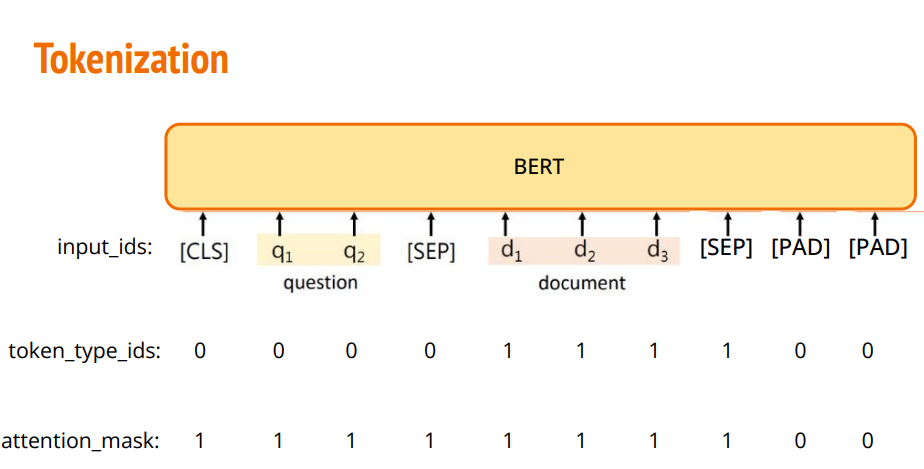

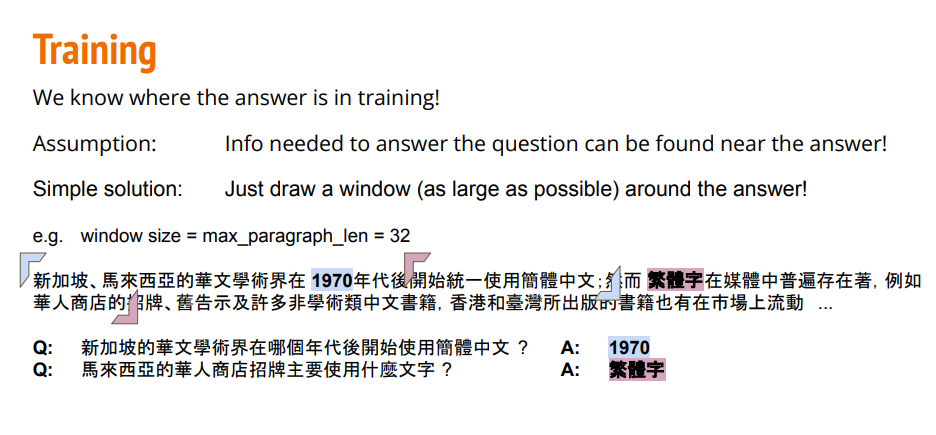
Training的情況: 以正確答案為中心去展開一個文章的window

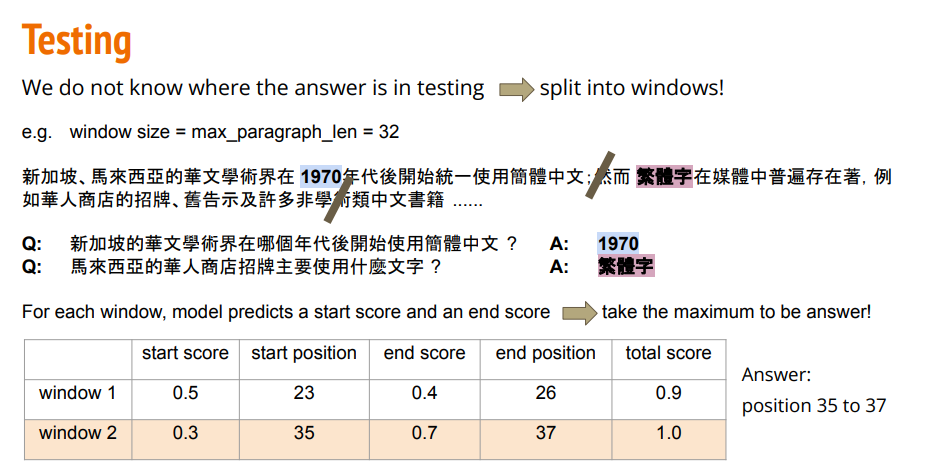
Testing的情況: 將文章切成很多小段落, 並預測每個段落的起始位置和終點位置得分, 取得分加起來最高的段落當成模型輸出的最終答案

In [8]:
from data import QA_Dataset
lines = inspect.getsource(QA_Dataset)
print(lines)

train_set = QA_Dataset("train", train_questions, train_questions_tokenized, train_paragraphs_tokenized)
dev_set = QA_Dataset("dev", dev_questions, dev_questions_tokenized, dev_paragraphs_tokenized)
test_set = QA_Dataset("test", test_questions, test_questions_tokenized, test_paragraphs_tokenized)

# Note: Do NOT change batch size of dev_loader / test_loader !
# Although batch size=1, it is actually a batch consisting of several windows from the same QA pair
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, pin_memory=True)
dev_loader = DataLoader(dev_set, batch_size=1, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)

class QA_Dataset(Dataset):
    def __init__(self, split, questions, tokenized_questions, tokenized_paragraphs):
        self.split = split
        self.questions = questions
        self.tokenized_questions = tokenized_questions
        self.tokenized_paragraphs = tokenized_paragraphs
        self.max_question_len = 40
        self.max_paragraph_len = 160
        
        ##### TODO: Change value of doc_stride #####
        # self.doc_stride = 150 # baseline
        self.doc_stride = 70 # medium

        # Input sequence length = [CLS] + question + [SEP] + paragraph + [SEP]
        self.max_seq_len = 1 + self.max_question_len + 1 + self.max_paragraph_len + 1

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        tokenized_question = self.tokenized_questions[idx]
        tokenized_paragraph = self.tokenized_paragraphs[question["paragraph_id"]]

        ##### TODO: Preprocessing #####
        # Hint: How 

## Function for Evaluation

In [9]:
from script import evaluate
lines = inspect.getsource(evaluate)
print(lines)

def evaluate(tokenizer, data, output):
    ##### TODO: Postprocessing #####
    # There is a bug and room for improvement in postprocessing 
    # Hint: Open your prediction file to see what is wrong 
    
    answer = ''
    max_prob = float('-inf')
    num_of_windows = data[0].shape[1]
    
    for k in range(num_of_windows):
        # Obtain answer by choosing the most probable start position / end position
        start_prob, start_index = torch.max(output.start_logits[k], dim=0)
        end_prob, end_index = torch.max(output.end_logits[k], dim=0)
        
        # Probability of answer is calculated as sum of start_prob and end_prob
        prob = start_prob + end_prob
        
        # Replace answer if calculated probability is larger than previous windows
        # if prob > max_prob:
        # Add condition for wrong (start & end) index and prevent too long answer
        if prob > max_prob and start_index <= end_index and end_index - start_index <= 20: 
            max_prob

## Training

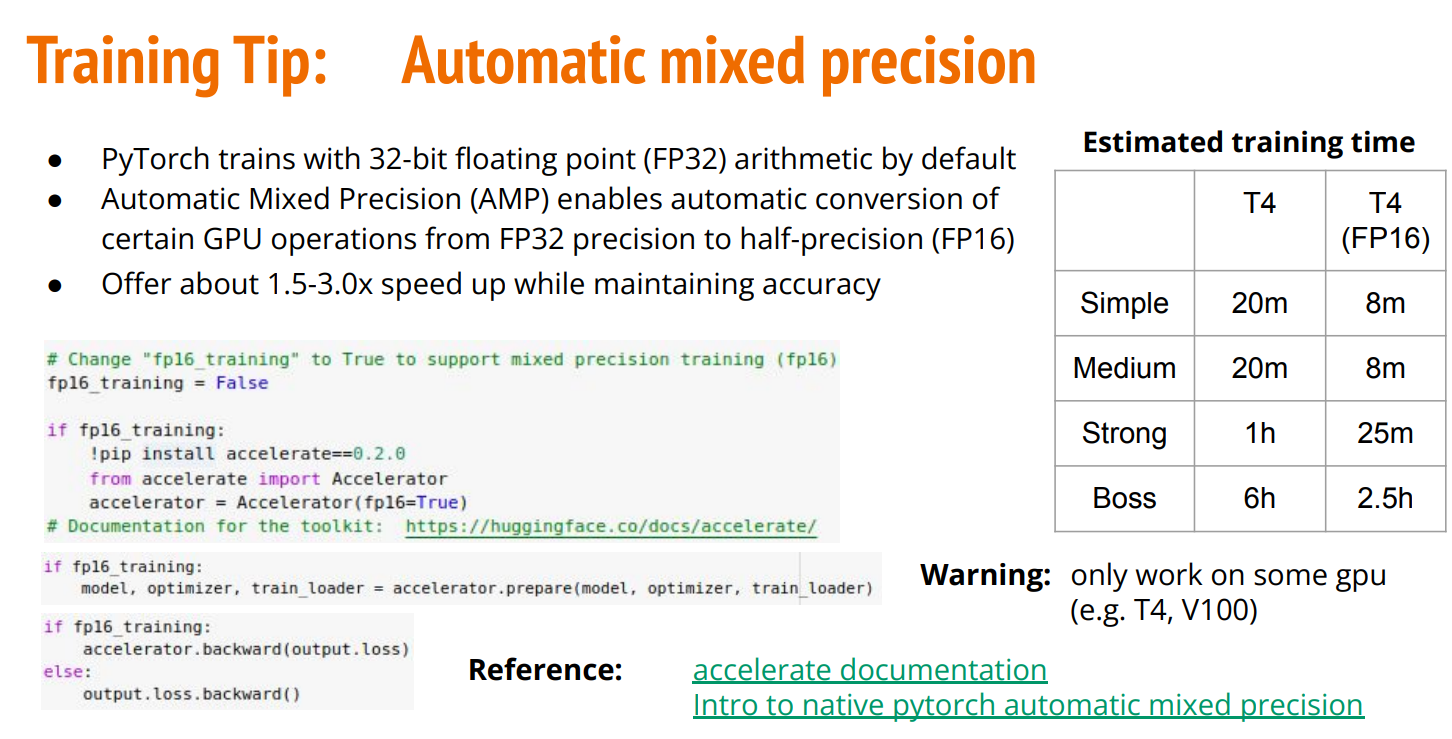
https://huggingface.co/docs/accelerate/index

In [10]:
from script import train
lines = inspect.getsource(train)
print(lines)

def train(learning_rate, num_epoch, model, optimizer, device, fp16_training, accelerator, train_loader, dev_loader, dev_questions, tokenizer):  
    validation = True
    logging_step = 900
    print("Start Training ...")
    total_steps = num_epoch * len(train_loader)
    gradient_acc = 1 # batch accumulation parameter
    warm_up_ratio = 0.1    
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = warm_up_ratio * total_steps, 
                                                num_training_steps = total_steps)

    for epoch in range(num_epoch):
        step = 1
        train_loss = train_acc = 0
        
        for data in tqdm(train_loader):	
            # Load all data into GPU
            data = [i.to(device) for i in data]
            
            # Model inputs: input_ids, token_type_ids, attention_mask, start_positions, end_positions (Note: only "input_ids" is mandatory)
            # Model outputs: start_

In [11]:
# num_epoch = 10
# # validation = True
# # logging_step = 100
# learning_rate = 1e-4
# optimizer = AdamW(model.parameters(), lr=learning_rate)

# if fp16_training:
#     model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader) 

# model.train()

# train(learning_rate, num_epoch, model, optimizer, device, fp16_training, accelerator, train_loader, dev_loader, dev_questions, tokenizer)

# # Save a model and its configuration file to the directory 「saved_model」 
# # i.e. there are two files under the direcory 「saved_model」: 「pytorch_model.bin」 and 「config.json」
# # Saved model can be re-loaded using 「model = BertForQuestionAnswering.from_pretrained("saved_model")」
# print("Saving Model ...")
# model_save_dir = "saved_model" 
# model.save_pretrained(model_save_dir)

######################################################

num_epoch = 4
# validation = True
# logging_step = 100
learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

if fp16_training:
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader) 

model.train()

train(learning_rate, num_epoch, model, optimizer, device, fp16_training, accelerator, train_loader, dev_loader, dev_questions, tokenizer)

# Save a model and its configuration file to the directory 「saved_model」 
# i.e. there are two files under the direcory 「saved_model」: 「pytorch_model.bin」 and 「config.json」
# Saved model can be re-loaded using 「model = BertForQuestionAnswering.from_pretrained("saved_model")」
print("Saving Model ...")
model_save_dir = "saved_model" 
model.save_pretrained(model_save_dir)

Start Training ...


  0%|          | 0/15845 [00:00<?, ?it/s]

Epoch 1 | lr 1.4184285263490061e-06 | Step 900 | loss = 5.279, acc = 0.000
Epoch 1 | lr 2.838434837488167e-06 | Step 1800 | loss = nan, acc = 0.022
Epoch 1 | lr 4.258441148627327e-06 | Step 2700 | loss = 2.501, acc = 0.293
Epoch 1 | lr 5.678447459766489e-06 | Step 3600 | loss = nan, acc = 0.573
Epoch 1 | lr 7.098453770905649e-06 | Step 4500 | loss = 1.436, acc = 0.632
Epoch 1 | lr 8.51846008204481e-06 | Step 5400 | loss = nan, acc = 0.649
Epoch 1 | lr 9.938466393183971e-06 | Step 6300 | loss = 1.460, acc = 0.651
Epoch 1 | lr 9.849058588408542e-06 | Step 7200 | loss = nan, acc = 0.670
Epoch 1 | lr 9.69128010939308e-06 | Step 8100 | loss = nan, acc = 0.669
Epoch 1 | lr 9.533501630377617e-06 | Step 9000 | loss = nan, acc = 0.684
Epoch 1 | lr 9.375723151362155e-06 | Step 9900 | loss = nan, acc = 0.695
Epoch 1 | lr 9.217944672346692e-06 | Step 10800 | loss = 1.324, acc = 0.686
Epoch 1 | lr 9.06016619333123e-06 | Step 11700 | loss = 1.347, acc = 0.699
Epoch 1 | lr 8.902387714315769e-06 | Ste

  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 1 | acc = 0.778


  0%|          | 0/15845 [00:00<?, ?it/s]

Epoch 2 | lr 8.175730163739e-06 | Step 900 | loss = nan, acc = 0.763
Epoch 2 | lr 8.017951684723538e-06 | Step 1800 | loss = 1.177, acc = 0.727
Epoch 2 | lr 7.860173205708074e-06 | Step 2700 | loss = 1.080, acc = 0.749
Epoch 2 | lr 7.702394726692613e-06 | Step 3600 | loss = 1.121, acc = 0.745
Epoch 2 | lr 7.544616247677151e-06 | Step 4500 | loss = nan, acc = 0.762
Epoch 2 | lr 7.3868377686616885e-06 | Step 5400 | loss = 0.997, acc = 0.777
Epoch 2 | lr 7.229059289646226e-06 | Step 6300 | loss = 1.146, acc = 0.769
Epoch 2 | lr 7.071280810630764e-06 | Step 7200 | loss = nan, acc = 0.794
Epoch 2 | lr 6.913502331615302e-06 | Step 8100 | loss = nan, acc = 0.755
Epoch 2 | lr 6.755723852599839e-06 | Step 9000 | loss = 1.062, acc = 0.796
Epoch 2 | lr 6.597945373584377e-06 | Step 9900 | loss = 0.950, acc = 0.785
Epoch 2 | lr 6.440166894568914e-06 | Step 10800 | loss = 1.080, acc = 0.769
Epoch 2 | lr 6.282388415553452e-06 | Step 11700 | loss = 1.094, acc = 0.757
Epoch 2 | lr 6.12460993653799e-06 

  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 2 | acc = 0.787


  0%|          | 0/15845 [00:00<?, ?it/s]

Epoch 3 | lr 5.397952385961222e-06 | Step 900 | loss = 0.790, acc = 0.815
Epoch 3 | lr 5.24017390694576e-06 | Step 1800 | loss = nan, acc = 0.813
Epoch 3 | lr 5.082395427930297e-06 | Step 2700 | loss = 0.847, acc = 0.815
Epoch 3 | lr 4.924616948914835e-06 | Step 3600 | loss = nan, acc = 0.797
Epoch 3 | lr 4.766838469899373e-06 | Step 4500 | loss = 0.875, acc = 0.814
Epoch 3 | lr 4.609059990883911e-06 | Step 5400 | loss = nan, acc = 0.825
Epoch 3 | lr 4.451281511868448e-06 | Step 6300 | loss = nan, acc = 0.828
Epoch 3 | lr 4.2935030328529855e-06 | Step 7200 | loss = 0.778, acc = 0.822
Epoch 3 | lr 4.135724553837524e-06 | Step 8100 | loss = 0.799, acc = 0.817
Epoch 3 | lr 3.977946074822061e-06 | Step 9000 | loss = 0.829, acc = 0.807
Epoch 3 | lr 3.820167595806599e-06 | Step 9900 | loss = nan, acc = 0.806
Epoch 3 | lr 3.662389116791137e-06 | Step 10800 | loss = 0.909, acc = 0.814
Epoch 3 | lr 3.5046106377756745e-06 | Step 11700 | loss = 0.878, acc = 0.811
Epoch 3 | lr 3.346832158760212e-0

  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 3 | acc = 0.794


  0%|          | 0/15845 [00:00<?, ?it/s]

Epoch 4 | lr 2.6201746081834438e-06 | Step 900 | loss = nan, acc = 0.824
Epoch 4 | lr 2.4623961291679816e-06 | Step 1800 | loss = nan, acc = 0.838
Epoch 4 | lr 2.3046176501525195e-06 | Step 2700 | loss = 0.756, acc = 0.839
Epoch 4 | lr 2.146839171137057e-06 | Step 3600 | loss = 0.731, acc = 0.843
Epoch 4 | lr 1.989060692121595e-06 | Step 4500 | loss = nan, acc = 0.842
Epoch 4 | lr 1.8312822131061325e-06 | Step 5400 | loss = 0.732, acc = 0.841
Epoch 4 | lr 1.6735037340906702e-06 | Step 6300 | loss = nan, acc = 0.847
Epoch 4 | lr 1.5157252550752078e-06 | Step 7200 | loss = 0.675, acc = 0.838
Epoch 4 | lr 1.3579467760597457e-06 | Step 8100 | loss = 0.714, acc = 0.833
Epoch 4 | lr 1.2001682970442831e-06 | Step 9000 | loss = nan, acc = 0.831
Epoch 4 | lr 1.042389818028821e-06 | Step 9900 | loss = nan, acc = 0.837
Epoch 4 | lr 8.846113390133587e-07 | Step 10800 | loss = 0.678, acc = 0.848
Epoch 4 | lr 7.268328599978963e-07 | Step 11700 | loss = 0.774, acc = 0.836
Epoch 4 | lr 5.6905438098243

  0%|          | 0/4131 [00:00<?, ?it/s]

Validation | Epoch 4 | acc = 0.789
Saving Model ...


# baseline
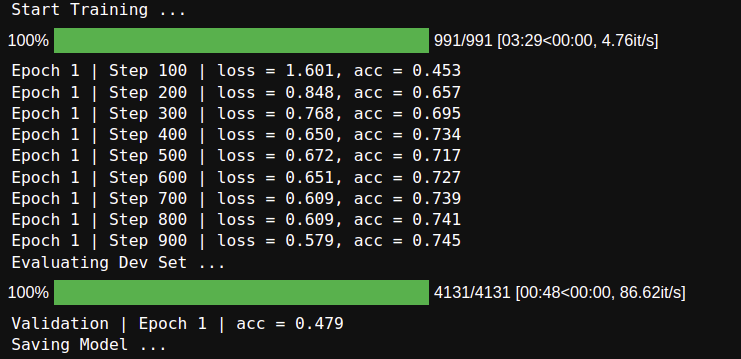

# Medium - decay1
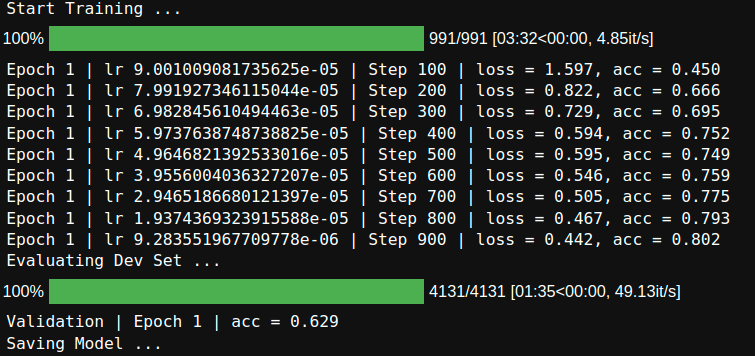

# Medium - decay2
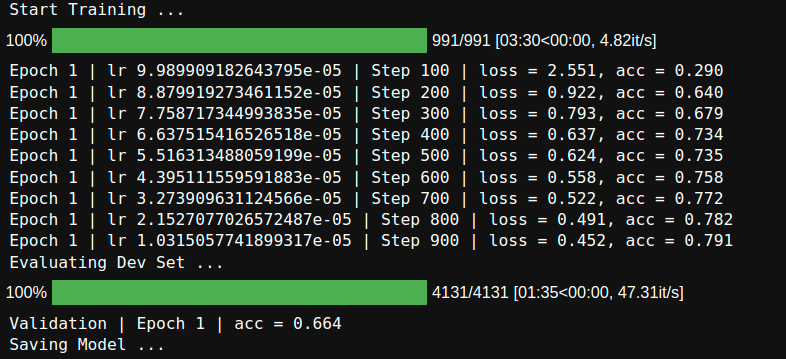

# Strong - decay1
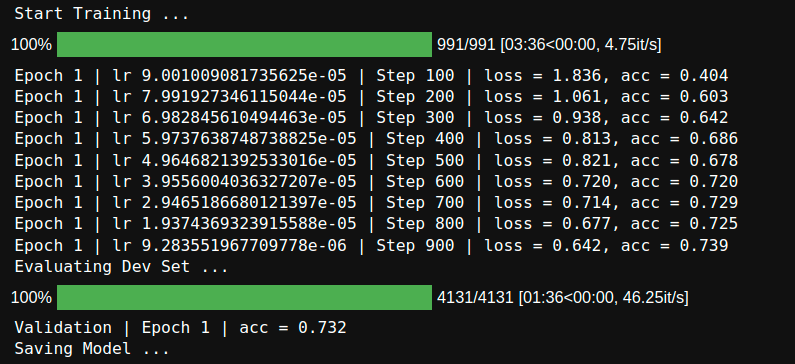

# Strong - decay2 (hfl/chinese-roberta-wwm-ext)
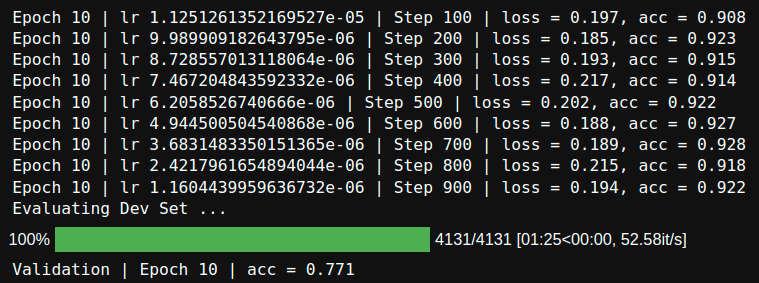

# Strong - decay2 (hfl/chinese-macbert-large)
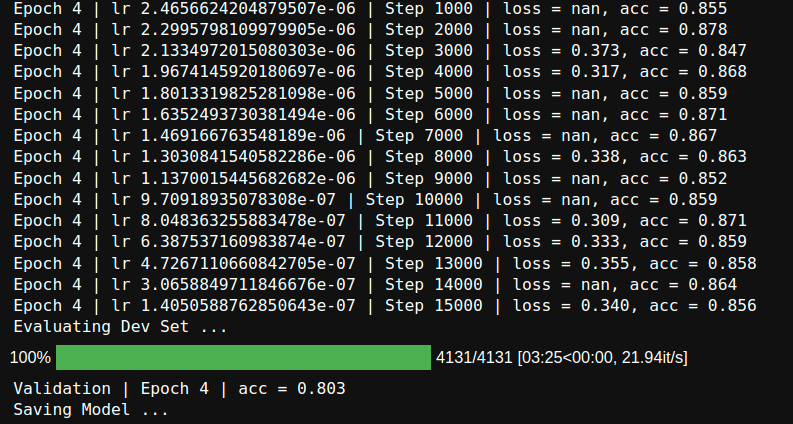

## Testing

In [ ]:
from script import test
lines = inspect.getsource(test)
print(lines)

test(model, test_loader, device, test_questions, tokenizer)

def test(model, test_loader, device, test_questions, tokenizer):      
    print("Evaluating Test Set ...")

    result = []

    model.eval()
    with torch.no_grad():
        for data in tqdm(test_loader):
            output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                        attention_mask=data[2].squeeze(dim=0).to(device))
            result.append(evaluate(tokenizer, data, output))

    result_file = "result.csv"
    with open(result_file, 'w') as f:    
        f.write("ID,Answer\n")
        for i, test_question in enumerate(test_questions):
            # Replace commas in answers with empty strings (since csv is separated by comma)
            # Answers in kaggle are processed in the same way
            f.write(f"{test_question['id']},{result[i].replace(',','')}\n")

    print(f"Completed! Result is in {result_file}")      

Evaluating Test Set ...


  0%|          | 0/4957 [00:00<?, ?it/s]